In [3]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
nest_asyncio.apply()# must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [4]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union


In [27]:
# Adjust your env variables here if nescesary
%pwd
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


In [28]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv('NUPLAN_HYDRA_CONFIG_PATH', 'config/simulation')

if os.environ.get('NUPLAN_HYDRA_CONFIG_PATH') is not None:
    CONFIG_PATH = os.path.join('../../../../', CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != 'simulation':
    CONFIG_PATH = os.path.join(CONFIG_PATH, 'simulation')
CONFIG_NAME = 'default_simulation'

In [34]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts

DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
#     'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.scenario_types=[starting_unprotected_cross_turn, near_multiple_vehicles]',  # [near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=2',  # use 10 scenarios per scenario type
#     'scenario_filter=one_continuous_log',  # simulate only one log
#     "scenario_filter.log_names=['2021.06.14.16.48.02_veh-12_04057_04438']",
     'scenario_filter.limit_total_scenarios=4',  # use 1 total scenarios
]
ckpt_dir = '/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt'
#'/home/sacardoz/checkpoints/urbandriver_checkpoint.ckpt'
#"/home/sacardoz/tutorial_vector_framework/training_simple_vector_experiment/train_default_simple_vector/2023.11.23.09.55.21/best_model/epoch.ckpt"
#"/home/sacardoz/training_raster_experiment/train_default_raster/2023.11.23.07.36.36/best_model/epoch.ckpt"
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    '+simulation=open_loop_boxes',# [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
    #'model=pgm_hybrid_model',
#     'planner=pdm_hybrid_planner',
#     f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}" ,
    'planner=log_future_planner', 
    #'planner.ml_planner.model_config=${model}',
    #f'planner.ml_planner.checkpoint_path={ckpt_dir}',
    #f'observation=idm_agents_observation',
    #'observation.model_config=${model}',
    #f'observation.checkpoint_path={ckpt_dir}',
    'worker=sequential',
    '+occlusion=true',
    '+occlusion.manager_type=wedge', #options: [range, shadow, wedge]
    "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
    *DATASET_PARAMS,
])

output_folder = cfg.output_dir
print(output_folder)

default_simulation
../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.08.20.26.52


# Now we can run with the following

Global seed set to 0


2023-12-08 20:26:55,563 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-12-08 20:26:55,563 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-12-08 20:26:55,582 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-12-08 20:26:55,582 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-12-08 20:26:55,734 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-08 20:26:55,734 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-08 20:26:55,735 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/

Rendering histograms: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


2023-12-08 20:27:22,441 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:02 [HH:MM:SS]
2023-12-08 20:27:22,441 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:02 [HH:MM:SS]
2023-12-08 20:27:22,442 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!
2023-12-08 20:27:22,442 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


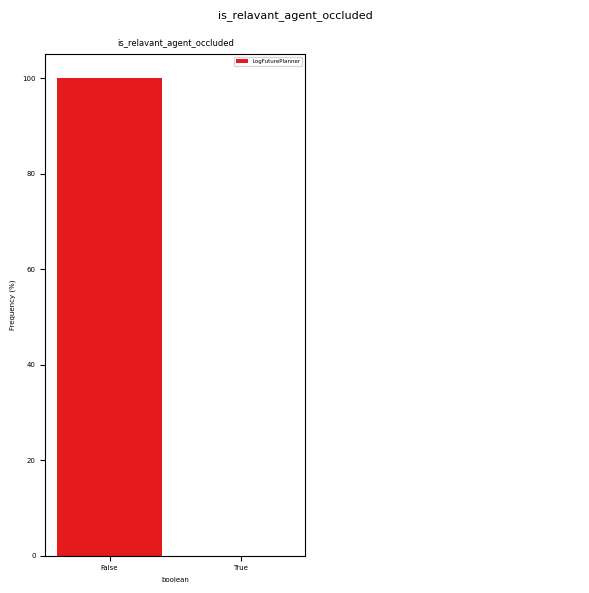

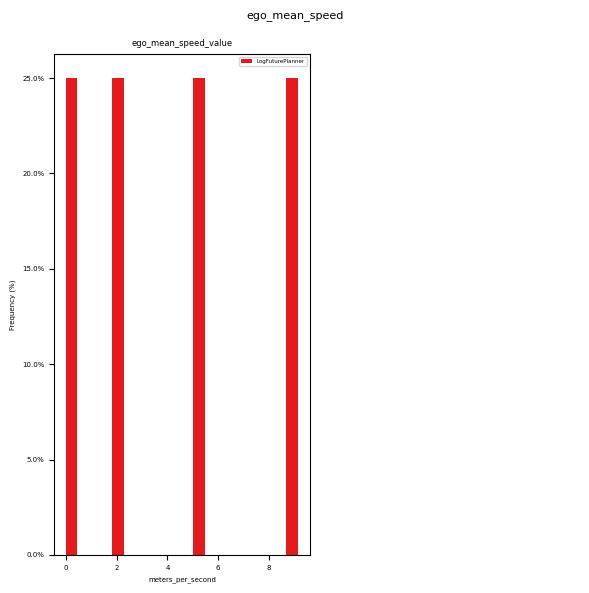

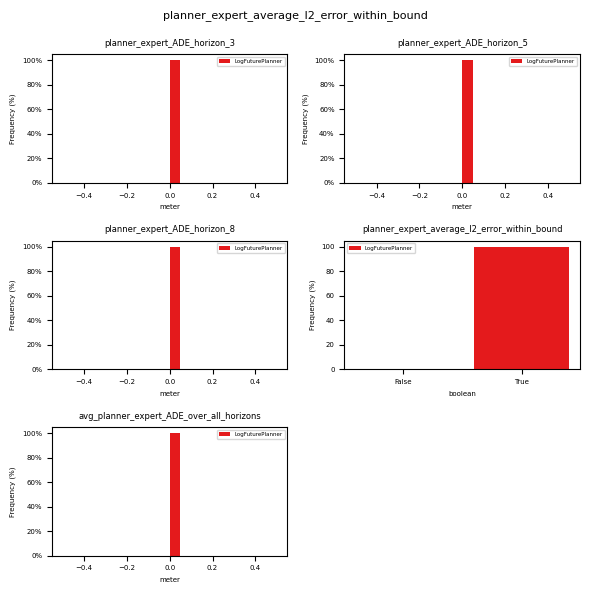

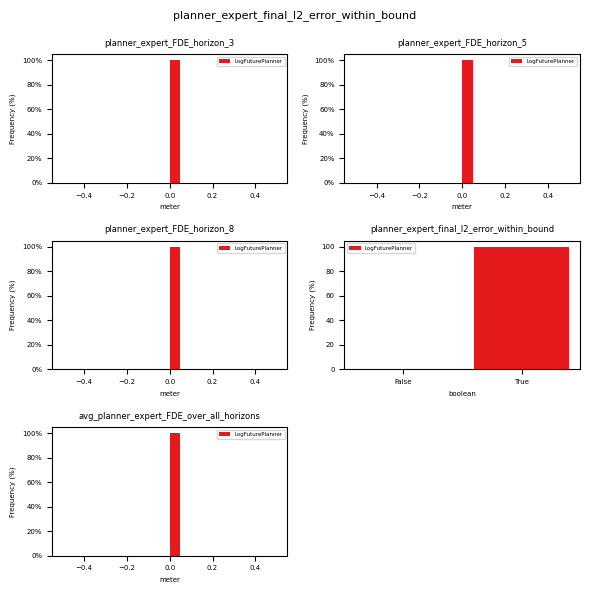

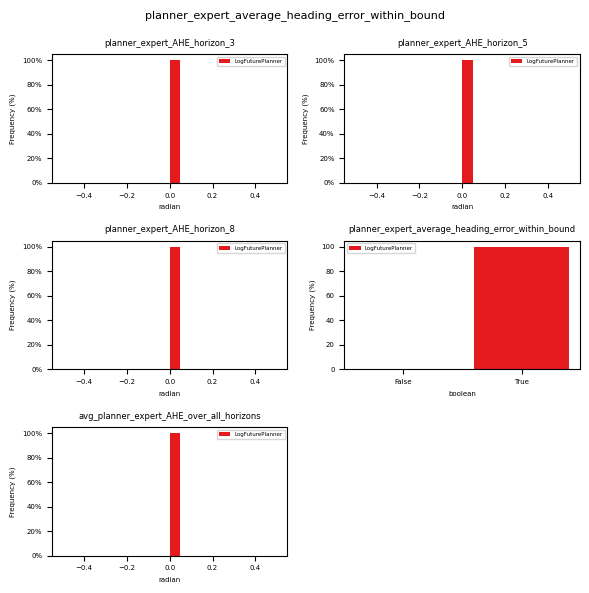

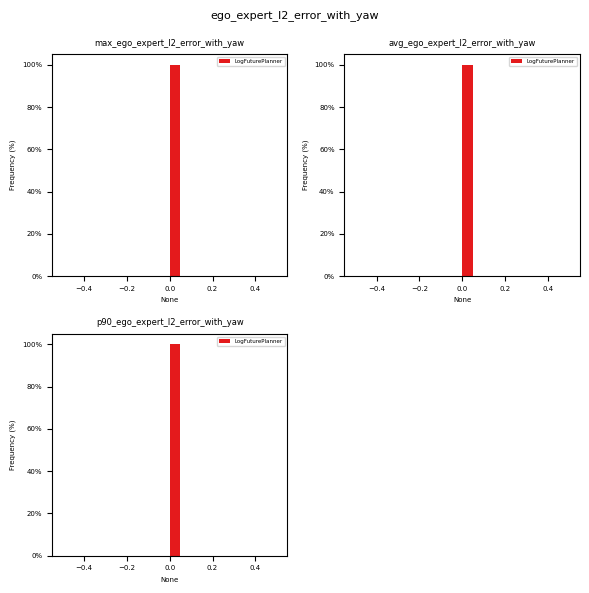

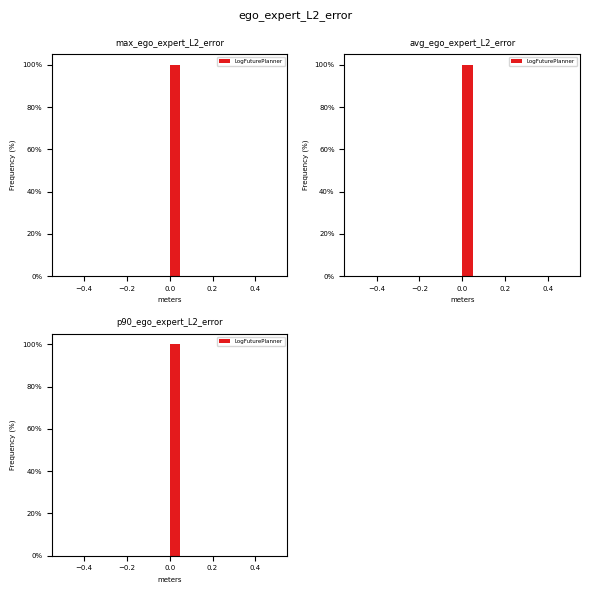

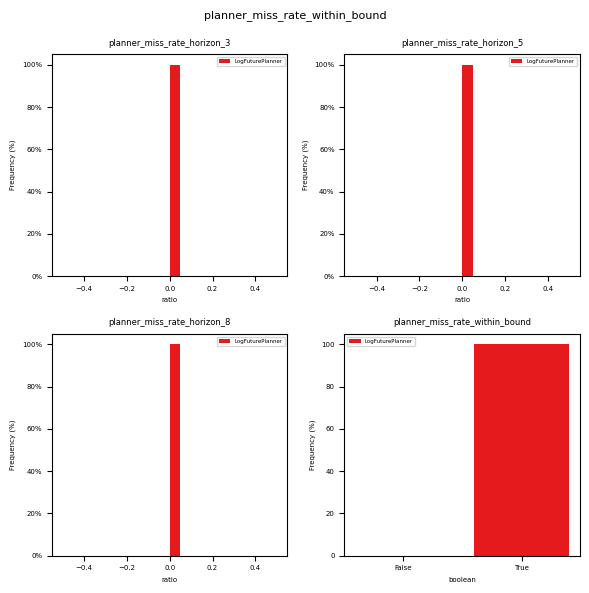

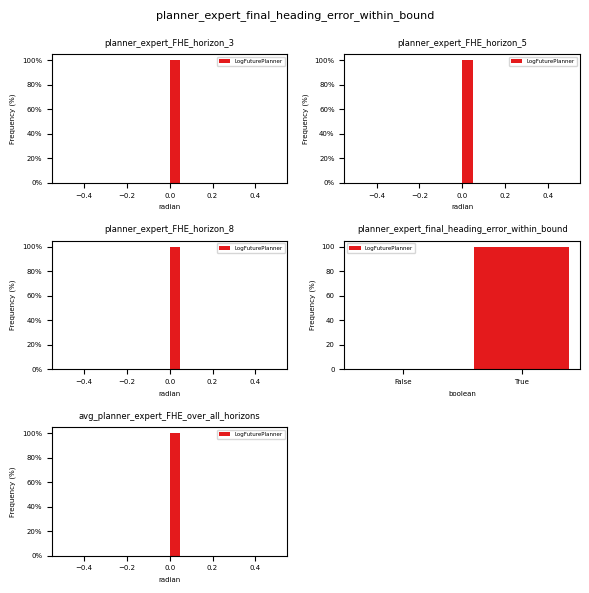

In [35]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [31]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={[output_folder]}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])


## Launch nuBoard (open in new tab - recommended)

In [32]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-12-08 20:23:16,606 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-08 20:23:16,606 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-08 20:23:16,616 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-08 20:23:16,616 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-08 20:23:16,617 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-08 20:23:16,617 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-08 20:23:16,617 INFO {/home/ehdykhne

INFO:tornado.access:200 GET / (127.0.0.1) 180.53ms
INFO:tornado.access:200 GET /resource/spectre.min.css (127.0.0.1) 2.75ms
INFO:tornado.access:200 GET /resource/spectre-icons.min.css (127.0.0.1) 0.27ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.34ms
INFO:tornado.access:200 GET /resource/style.css (127.0.0.1) 0.28ms
INFO:tornado.access:200 GET /resource/css/overview.css (127.0.0.1) 0.48ms
INFO:tornado.access:200 GET /resource/css/cloud.css (127.0.0.1) 0.44ms
INFO:tornado.access:200 GET /resource/css/histogram.css (127.0.0.1) 0.36ms
INFO:tornado.access:200 GET /resource/css/scenario.css (127.0.0.1) 0.26ms


2023-12-08 20:23:17,503 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-icons.min.css (127.0.0.1) 0.27ms
2023-12-08 20:23:17,503 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-icons.min.css (127.0.0.1) 0.27ms
2023-12-08 20:23:17,512 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.34ms
2023-12-08 20:23:17,512 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.34ms
2023-12-08 20:23:17,516 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/style.css (127.0.0.1) 0.28ms
2023-12-08 20:23:17,516 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /reso

INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=3c61e952b808bb7e346ce828a565a5f23aaf7708d034fa9d0906403813355d45bb4e8d8b0b23a93f032c76831d4f0221846f28699c7f5147caa62e0d31668314 (127.0.0.1) 1.14ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=e5df31fd9010eacff0aa72d315264604b5e34972ba445acea6fce98080eecf33acf2d2986126360faaa5852813cffa16f6f6f4889923318300f062497c02da4e (127.0.0.1) 0.39ms
INFO:tornado.access:200 GET /static/js/bokeh-widgets.min.js?v=8a1ff6f5aa0d967f4998d275803bbb111d928fd9f605ef9e1f30cfd021df0e77224ee3d13f83edb3a942f6e4ccc569ee5dd8951a8aa6cb600602463b90c65a87 (127.0.0.1) 0.46ms
INFO:tornado.access:200 GET /static/js/bokeh-tables.min.js?v=ae2903e57cf57f52819fdf4d938c648982b51c34f73b6e653a0f3bb3c8ab44f338505931ace43eafc1636e215492e2314acf54c54baffb47813b86b4923a7fe0 (127.0.0.1) 0.68ms


2023-12-08 20:23:17,748 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-widgets.min.js?v=8a1ff6f5aa0d967f4998d275803bbb111d928fd9f605ef9e1f30cfd021df0e77224ee3d13f83edb3a942f6e4ccc569ee5dd8951a8aa6cb600602463b90c65a87 (127.0.0.1) 0.46ms
2023-12-08 20:23:17,748 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-widgets.min.js?v=8a1ff6f5aa0d967f4998d275803bbb111d928fd9f605ef9e1f30cfd021df0e77224ee3d13f83edb3a942f6e4ccc569ee5dd8951a8aa6cb600602463b90c65a87 (127.0.0.1) 0.46ms
2023-12-08 20:23:17,784 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-tables.min.js?v=ae2903e57cf57f52819fdf4d938c648982b51c34f73b6e653a0f3bb3c8ab44f338505931ace43eafc1636e215492e2314acf54c54baffb47813b86b4923a7fe0 (127.0.0.1) 0.68ms
2023-12-08 20:23:17,784 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/pytho

INFO:tornado.access:200 GET /resource/scripts/utils.js (127.0.0.1) 0.72ms
INFO:tornado.access:200 GET /static/js/bokeh-mathjax.min.js?v=176c36fdbcd8fc1019fc828101a2804081a35baf4018d7f2633cd263156b593aa73112f400112b662daa0590138b74851bc91f1f2a5fbf5416ee8c876c3e0d0c (127.0.0.1) 2.06ms
INFO:tornado.access:200 GET /resource/motional_logo.png (127.0.0.1) 2.27ms


2023-12-08 20:23:18,678 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-08 20:23:18,678 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-08 20:23:18,683 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0005 seconds.
2023-12-08 20:23:18,683 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0005 seconds.
2023-12-08 20:23:18,774 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 153.62ms
2023-12-08 20:23:18,774 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 153.62ms
2023-12-08 20:23:18,783 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:

INFO:tornado.access:200 GET / (127.0.0.1) 153.62ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.31ms


KeyboardInterrupt: 